# SWE gravity wave via tensor train (TT)

We will solve the 2D, linearized SWE (dimensionless) gravity wave subsystem:
\begin{align*}
\partial_t u &= -c\ \partial_x h \\
\partial_t v &= -c\ \partial_y h \\
\partial_t h &= -c\ \left( \partial_x u + \partial_y v \right) \,,
\end{align*}
where $ c $ is the wave propigation speed, 
$ u $ is the fluid velocity in the $ x $-direction,
$ v $ is the fluid velocity in the $ y $-direction,
and $ h $ is the fluid layer thickness.
Note that all qauntities are dimensionless.

Assuming the appropriate smoothness, we can write the above as the wave equation in 2D:
$$ \partial_t^2 h = c^2\ \Delta h \,. $$

For simplicity, we will solve this system with a centered finite difference discretization in space and a Runge-Kutta time-discretization.
The domain is a simple rectangular, cartesian grid.
Finally, we assume no-flow boundary conditions (i.e. zero boundary conditions).

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchtt as tt

from timer import Timer

Set up parameters and a rectangular grid for the problem. Since we are aiming for a quantized tensor train formulation of the problem, we will force a grid size that is a power of 2.

This also defines the shape of our tensors. Say that the grid has size $ 2^L $, then the TT tensors will have shape `[2] * L` and our TT operators will have shape `[(2, 2)] * L`.

Throughout, we will differentiate between **TT tensors** and **TT operators**. TT tensors are analogous to vectors, and are indexed by a 1D multi-index of dimension $ \tilde{M} $, $ \mathbf{i} = (i_1, \cdots, i_{\tilde{M}}) $. TT operators are analogous to matrices and are indexed by a 2D multi-index with $ \tilde{M} $ ''rows'' and $ \tilde{N} $ ''columns'', $ \mathbf{i} \times \mathbf{j} = (i_1, \cdots, i_{\tilde{M}}) \times (j_1, \cdots, j_{\tilde{N}}) $.

In [2]:
# parameters
c = 1  # wave propigation speed

xmin = -1
xmax = 2

ymin = -1
ymax = 1


# uniform cartesian grid
N = 2**8  # size in x-direction
M = 2**7  # size in y-direction

xgrid = np.linspace(xmin, xmax, N)
ygrid = np.linspace(ymin, ymax, M)

x, y = np.meshgrid(xgrid, ygrid)

dx = (xmax - xmin) / (N-1)
dy = (ymax - ymin) / (M-1)


# shapes for QTT representations
L = int(math.log(M*N, 2))
qtt_tens_shape = [2] * L
qtt_op_shape = [(2, 2)] * L

Initially, assume that each of $ u $, $ v $, and $ h $ will be represented as length $ MN $ vectors, given by flattened matrices of their values on the 2D grid. To get the value of a given variable at the `[i, j]` location on the 2D grid, we index our 1D vectors as `[N*i + j]`. Note that these are 0-indexed arrays.

Then, we can build the RHS operators as $ MN \times MN $ matrices. Since we are assuming zero boundary conditions, the boundary values of the operator matrices are set to zero.

In [3]:
Dx = np.zeros([M*N, M*N])  # d/dx
Dy = np.zeros([M*N, M*N])  # d/dy

for i in range(1, M-1):
    for j in range(1, N-1):
        Dx[N*i + j, N*i + (j-1)] = -1
        Dx[N*i + j, N*i + (j+1)] = 1
        
        Dy[N*i + j, N*(i-1) + j] = -1 
        Dy[N*i + j, N*(i+1) + j] = 1
    # END for
# END for

Dx = Dx / (2*dx)
Dy = Dy / (2*dy)

Next, we form the QTT representations for these matrix operators using `torchtt`, a tensor train library built on `torch`. As discussed above, these will be TT operators with shape `[(2, 2)] * L`. These TT operators will operate on TT tensors with shape `[2] * L`.

As an example, we perform a "matrix-vector multiply" between the TT operator for $ \frac{\text{d}}{\text{d}x} $ and the TT tensor represenation of the initial condition for $ h $. This uses the `@` operator defined by `torchtt`, which is a generalization of the martix-vector product. Then, to control the number of ranks in the result, we perform a TT rounding to obtain a lower rank approximation at the default error tolerance `eps=1e-12`. Note the *vastly* improved compression between the rounded and unrounded TT.

In [4]:
# create timer to use in these examples
ex_timer = Timer()

# form TT operators
ex_timer.start()
Dx_qtt = tt.TT(Dx, qtt_op_shape)
ex_timer.stop()
print(f'Dx_qtt = \n{Dx_qtt}Time to .TT() = {ex_timer.get_time_reset():.3}\n')

Dy_qtt = tt.TT(Dy, qtt_op_shape)


# build initial condition for h
# Gaussian bump centered in the domain
gbump_height = 0.1
gbump = gbump_height * np.exp( -25*( (x - (xmax+xmin)/2)**2 + (y - (ymax+ymin)/2)**2 ) )

ex_timer.start()
gbump_qtt = tt.TT(gbump, qtt_tens_shape)
ex_timer.stop()
print(f'gbump_qtt =\n{gbump_qtt}Time to .TT() = {ex_timer.get_time_reset():.3}\n')


# example multiplication and TT rounding
ex_timer.start()
mult_example = Dx_qtt @ gbump_qtt
ex_timer.stop()
print(f'Dx_qtt @ gbump_qtt =\n{mult_example}Time to @ = {ex_timer.get_time_reset():.3}\n')

ex_timer.start()
mult_example_round = mult_example.round()
ex_timer.stop()
print(f'mult_example.round() =\n{mult_example_round}Time to .round() = {ex_timer.get_time_reset():.3}\n')

Dx_qtt = 
TT-matrix with sizes and ranks:
M = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
N = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
R = [1, np.int64(2), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(2), np.int64(1), 4, np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(2), 1]
Device: cpu, dtype: torch.float64
#entries 716 compression 6.668269634246826e-07
Time to .TT() = 23.7

gbump_qtt =
TT with sizes and ranks:
N = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
R = [1, 2, 4, 8, np.int64(8), np.int64(4), np.int64(2), np.int64(1), 2, 4, np.int64(6), np.int64(9), 8, 4, 2, 1]

Device: cpu, dtype: torch.float64
#entries 700 compression 0.0213623046875
Time to .TT() = 0.00238

Dx_qtt @ gbump_qtt =
TT with sizes and ranks:
N = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
R = [1, 4, 12, 24, 24, 12, 4, 1, 8, 20, 30, 45, 40, 20, 4, 1]

Device: cpu, dtype: torch.float64
#entries 12116 compression 0.3697509765625
Time to @ = 0.00226

mult_example.r

Our TT operators have fantastic compression versus the full tensor operators.
Those full tensor operators are sparse, how sparse are the individual cores in the TT representation?
Here, we are looking at the "density" of each core and that of the full tensor, i.e. the number of nonzero entries divided by the total size.

We can see that each core is **not** sparse.
Intuitivly, this makes some sense -- if the TT algorithm seeks to compress a tensor as much as possible, it should cut out as much "useless" information as possible.

In [5]:
for i, core in enumerate(Dx_qtt.cores):
    nnz = int( torch.count_nonzero(core) )
    print(f'density in core {i} = {nnz / (core.shape[0]*core.shape[1]*core.shape[2]*core.shape[3])}')
# END for

print(f'\ndensity in full tensor = {np.count_nonzero(Dx) / Dx.shape[0]**2}')

density in core 0 = 0.5
density in core 1 = 0.5416666666666666
density in core 2 = 0.5833333333333334
density in core 3 = 0.5277777777777778
density in core 4 = 0.5277777777777778
density in core 5 = 0.5
density in core 6 = 0.5
density in core 7 = 0.375
density in core 8 = 0.6
density in core 9 = 0.96
density in core 10 = 0.97
density in core 11 = 0.98
density in core 12 = 1.0
density in core 13 = 1.0
density in core 14 = 1.0

density in full tensor = 5.961209535598755e-05


In [6]:
# create the state variable(s)
# make a 2 X 3 ndarray, where 
# indexes along the first axis are time levels
# indexes along the second axis are 
#     0: u
#     1: v
#     2: h
# each entry in this matrix is the TT representaion
# of the given variable at the given time-level
state = np.full( [2, 3], tt.zeros(qtt_tens_shape) )


#  matrix operator tendency routine
def rhs_qtt(state):
    rhs = np.full( 3, tt.zeros(qtt_tens_shape) )

    rhs[0] = ( -c * Dx_qtt @ state[2] ).round()
    rhs[1] = ( -c * Dy_qtt @ state[2] ).round()
    rhs[2] = ( -c * ( Dx_qtt @ state[0] + 
                      Dy_qtt @ state[1] ) ).round()

    return rhs
# END rhs_qtt()


# RK4
def rk4_step(state, rhs):
    s1 = rhs(state)

    s2 = rhs( state + (dt/2)*s1 )

    s3 = rhs( state + (dt/2)*s2 )

    s4 = rhs( state + dt*s3 )

    return ( state + (dt/6)*( s1 + 2*s2 + 2*s3 + s4 ) )
# END rk4_step()

We set the initial condition as a Gaussian bump of a given height centered in the domain, then begin time-stepping with RK4.

In [7]:
# create timers
rk4_timer = Timer()
rounding_timer = Timer()

# initial conditions
state[0, 0] = tt.zeros(qtt_tens_shape)
state[0, 1] = tt.zeros(qtt_tens_shape)
state[0, 2] = tt.TT(gbump, qtt_tens_shape)

# time-stepping
dt = 0.01
nsteps = 70

for istep in range(0, nsteps):
    rk4_timer.start()
    state[(istep+1)%2, :] = rk4_step(state[istep%2, :], rhs_qtt)
    rk4_timer.stop()

    # after each time-step, perform a TT round on each variable
    rounding_timer.start()
    for n in range(0, 3):
        state[(istep+1)%2, n] = state[(istep+1)%2, n].round()
    # END for
    rounding_timer.stop()
# END for


# create timer report
rk4_time = rk4_timer.get_time_reset()
rounding_time = rounding_timer.get_time_reset()

print(f'nsteps = {nsteps}\n')
print(f'total time = {rk4_time + rounding_time:.3}')
print(f'\trk4 time = {rk4_time:.3}')
print(f'\trounding time = {rounding_time:.3}\n')

print(f'avg time per step = {(rk4_time + rounding_time) / nsteps:.3}')
print(f'\tavg time rk4 = {rk4_time / nsteps:.3}')
print(f'\tavg time rounding = {rounding_time / nsteps:.3}')

nsteps = 70

total time = 0.0892
	rk4 time = 0.0812
	rounding time = 0.008

avg time per step = 0.00127
	avg time rk4 = 0.00116
	avg time rounding = 0.000114


Notes
- Memory usage and time to `tt.TT()` on the operators (which have $ (MN)^2 $ entries) explodes as the problem size increases.
    - Feels like we are capping out around `M*N = 2**(7+8) = 32768` on the M3 Max LANL Mac. Can technically run at `M*N = 2**(8+8) = 65536`, but then we get this error while time-stepping:
        ```
        /Users/jlilly/.pyenv/tt/lib/python3.12/site-packages/torchTT-2.0-py3.12-macosx-14.0-arm64.egg/torchtt/_decomposition.py:313: RuntimeWarning: overflow encountered in square
            sc = np.cumsum(np.abs(s[::-1])**2)[::-1]
        ```
    - This will be a problem as we move towards realistic meshes on the sphere. At the very least we will probably need to build/store the TT operators when the IC files are generated, never at runtime (since the operators only depend on the mesh).
    - I don't know if this behavior is expected, or if there is a problem with `torchtt` (memory leak? probably not, because python...).
- Home machine crashed without applying rounding after each RHS multiplication -- 30+ GB of memory usage. Seems to cap at a very resonable value if we round after each `@`.
    - Additionally, things are *very* slow if we don't round after every `@` -- for now, we are rounding after each `@` and after each time-step.
- We can acheive a QTT representation (it seems) via `tt.TT(tens).to_qtt()` if `tens` is the right size. We will explicitly pass in the shape we want rather than using `TT.to_qtt()` for now -- passing in the correct shape gives equivalent results.
- We have a problem where we are getting negative values at/near the boundary in the first few time-steps (e.g. run with `nsteps = 1`), probably due to the TT error. Not sure how to deal with that yet, or if it is even a problem long term.

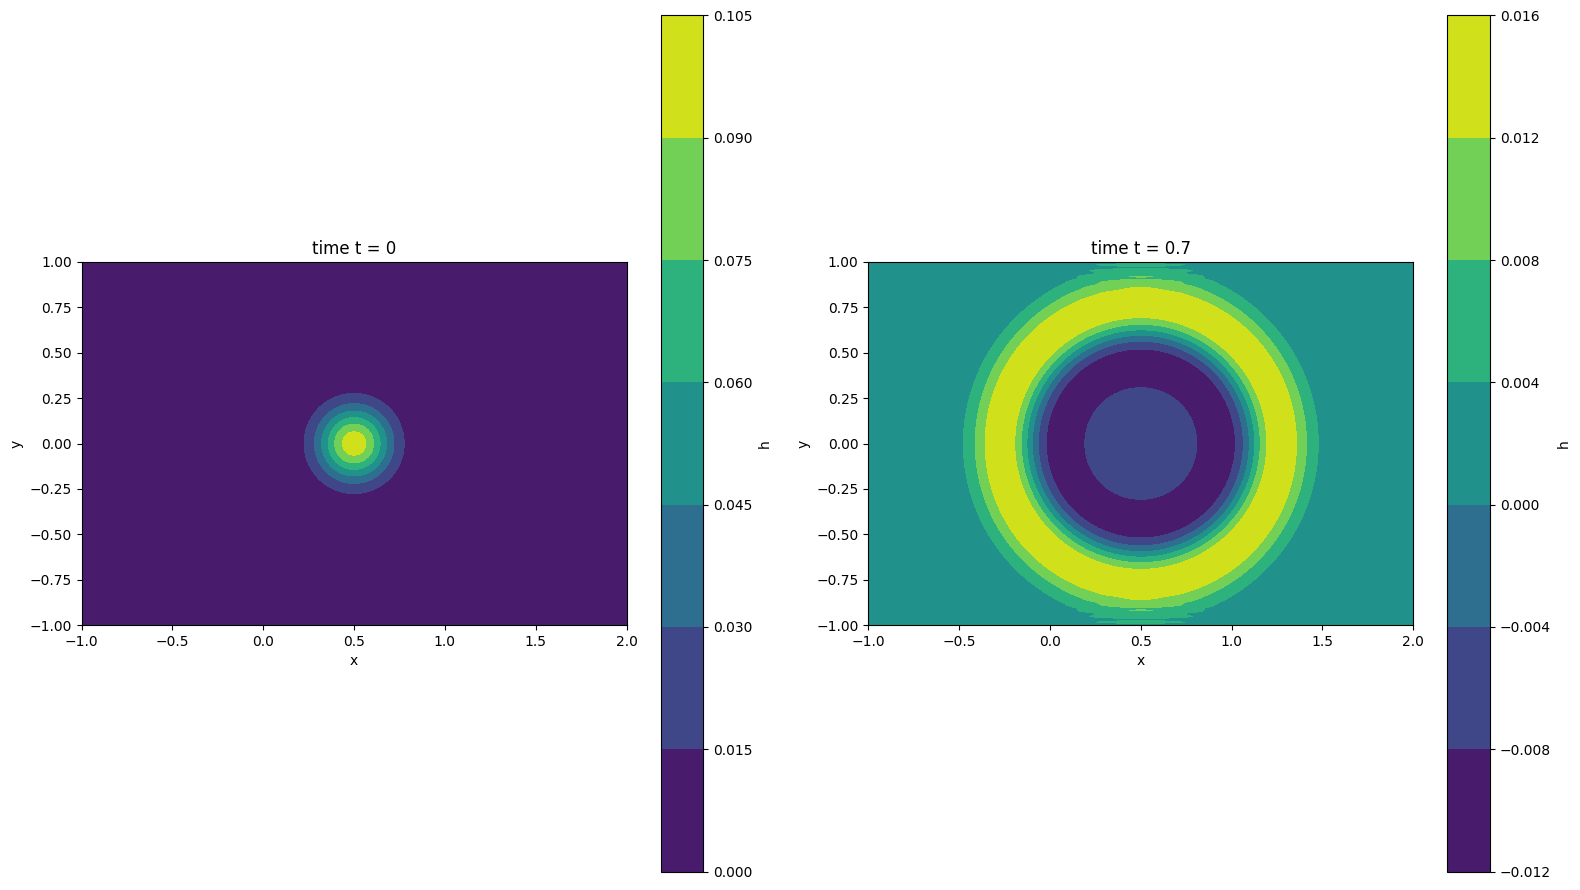

In [8]:
# visualization
h = tt.TT.full( state[nsteps%2, 2] ).numpy().reshape([M, N])

fig, axes = plt.subplots(1, 2, figsize=[16,9])

#csInitial = axes[0].pcolormesh(x, y, gbump)
#csFinal = axes[1].pcolormesh(x, y, h)
csInitial = axes[0].contourf(x, y, gbump)
csFinal = axes[1].contourf(x, y, h)

axes[0].set_xlim(xmin, xmax)
axes[0].set_ylim(ymin, ymax)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_aspect('equal')
axes[0].set_title('time t = 0')

axes[1].set_xlim(xmin, xmax)
axes[1].set_ylim(ymin, ymax)
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_aspect('equal')
axes[1].set_title('time t = {:.2}'.format(dt*nsteps))

cbarInitial = fig.colorbar(csInitial)
cbarInitial.set_label('h')

cbarFinal = fig.colorbar(csFinal)
cbarFinal.set_label('h')

fig.tight_layout()
plt.show()